# Read LIB

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# avoid decoding problems
df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.shape

(404290, 6)

# Load nlp_features_train & df_fe_without_preprocessing_train

In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('/content/drive/My Drive/Quora/nlp_features_train.csv'):
    dfnlp = pd.read_csv("/content/drive/My Drive/Quora/nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('/content/drive/My Drive/Quora/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("/content/drive/My Drive/Quora/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
dfnlp.shape


(404290, 21)

In [0]:
df1 = dfnlp.drop(['qid1','qid2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [0]:
df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [0]:
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [0]:
df3.head(3)

,id
0,0
1,1
2,2


In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])

Number of features in nlp dataframe : 19
Number of features in preprocessed dataframe : 12


# Merging featured data

In [0]:
df1  = df1.merge(df2, on='id',how='left')

df1.shape

(404290, 30)

In [0]:
df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


# Preprocessing of ques1 & ques2

In [0]:
df1["question1"] = df1["question1"].fillna("")
df1["question2"] = df1["question2"].fillna("")

In [0]:
df1.isnull().any().any()

False

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\',000,000", " m", phrase)
    phrase = re.sub(r"\',000", " k", phrase)
    phrase = re.sub(r"\'₹", " rupee", phrase)
    phrase = re.sub(r"\'%", " percent", phrase)
    phrase = re.sub(r"\'$", " dollar", phrase)
    
    return phrase

In [0]:
 import nltk
nltk.download('stopwords')

stopwords = stopwords.words("english")
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_ques1 = []
# tqdm is for printing the status bar
for sentance in tqdm(df1["question1"].values):
    sentance = str(sentance).lower()
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = re.sub(r"([0-9]+)000000", r"\1m", sentance)
    sentance = re.sub(r"([0-9]+)000", r"\1k", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_ques1.append(sentance.strip())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 404290/404290 [01:53<00:00, 3569.78it/s]


In [0]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_ques2 = []
# tqdm is for printing the status bar
for sentance in tqdm(df1["question2"].values):
    sentance = str(sentance).lower()
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = re.sub(r"([0-9]+)000000", r"\1m", sentance)
    sentance = re.sub(r"([0-9]+)000", r"\1k", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_ques2.append(sentance.strip())

100%|██████████| 404290/404290 [01:55<00:00, 3492.30it/s]


In [0]:
df1["preprocessed_q1"] = preprocessed_ques1
df1["preprocessed_q2"] = preprocessed_ques2

df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,step step guide invest share market india,step step guide invest share market
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,increase speed internet connection using vpn,internet speed increased hacking dns


# Train Test Split

In [0]:
# Take randomly 100K points

df1 = df1.sample(n=100000)

df1.shape

(100000, 32)

In [0]:
from sklearn.model_selection import train_test_split

df1.drop(df1.index[0],inplace = True)

y = df1["is_duplicate"]
df1.drop(['is_duplicate',"question1","question2"], axis=1, inplace=True)

x = df1

x.head(3)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
49299,49299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.0,11.5,45,44,42,43,0.100000,1,1,81,49,13,8,0.0,20.0,0.000000,2,0,necessary strong mathematics base learn machin...,someone decipher meaning batman r p
75615,75615,0.666656,0.571420,0.666656,0.571420,0.615380,0.499997,0.0,1.0,3.0,14.5,84,82,73,62,0.310811,5,6,96,73,16,12,6.0,25.0,0.240000,11,1,predictions polls wrong results presidential e...,prediction polls u presidential election wrong
115310,115310,0.499988,0.499988,0.999975,0.799984,0.749991,0.599994,0.0,1.0,2.0,9.0,79,65,75,80,0.652174,5,1,50,45,10,8,6.0,17.0,0.352941,6,4,average height humans world,average height american males


In [0]:
x.shape

(99999, 29)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)



In [0]:
print("Number of data points in train data :",X_train.shape,y_train.shape)
print("Number of data points in test data :",X_test.shape,y_test.shape)

Number of data points in train data : (69999, 29) (69999,)
Number of data points in test data : (30000, 29) (30000,)


# Tf-IDf on ques1 & ques 2

In [0]:
# On Clean Essay
#from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(ngram_range = (1,4))
preprocessed_ques1_tfidf_train = vectorizer1.fit_transform(X_train['preprocessed_q1'])
#preprocessed_ques1_tfidf_train = normalize(preprocessed_ques1_tfidf_train,axis = 0)

print("Shape of matrix after one hot encodig ",preprocessed_ques1_tfidf_train.shape)

preprocessed_ques1_tfidf_test = vectorizer1.transform(X_test['preprocessed_q1'])
#preprocessed_ques1_tfidf_test = normalize(preprocessed_ques1_tfidf_test,axis = 0)

print("Shape of matrix after one hot encodig ",preprocessed_ques1_tfidf_test.shape)

Shape of matrix after one hot encodig  (69999, 562925)
Shape of matrix after one hot encodig  (30000, 562925)


In [0]:
# On Clean_title 

vectorizer2 = TfidfVectorizer(ngram_range = (1,4))
preprocessed_ques2_tfidf_train = vectorizer2.fit_transform(X_train['preprocessed_q2'])
#preprocessed_ques2_tfidf_train = normalize(preprocessed_ques2_tfidf_train,axis = 0)

print("Shape of matrix after one hot encodig ",preprocessed_ques2_tfidf_train.shape)

preprocessed_ques2_tfidf_test = vectorizer2.transform(X_test['preprocessed_q2'])
#preprocessed_ques2_tfidf_test = normalize(preprocessed_ques2_tfidf_test,axis = 0)

print("Shape of matrix after one hot encodig ",preprocessed_ques2_tfidf_test.shape)

Shape of matrix after one hot encodig  (69999, 571515)
Shape of matrix after one hot encodig  (30000, 571515)


# Take all features together for train our model

In [0]:
# Remove undesried columns

X_train_idf = X_train.drop(['id','preprocessed_q1','preprocessed_q2'],axis=1,inplace = False)

print(X_train_idf.shape)

X_train_idf.head(2)

(69999, 26)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
312461,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,1.0,1.0,1.0,6.5,81,79,90,84,0.681818,2,2,48,43,7,6,5.0,13.0,0.384615,4,0
296943,0.999967,0.999967,0.999967,0.599988,0.999983,0.749991,1.0,1.0,2.0,7.0,100,92,92,85,0.571429,1,2,40,34,8,6,6.0,14.0,0.428571,3,1


In [0]:
# Remove undesried columns

X_test_idf = X_test.drop(['id','preprocessed_q1','preprocessed_q2'],axis=1,inplace = False)

print(X_test_idf.shape)

X_test_idf.head(2)

(30000, 26)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
90353,0.599988,0.499992,0.499988,0.399992,0.499995,0.416663,0.0,1.0,2.0,11.0,67,55,43,43,0.254545,2,3,54,65,10,12,5.0,20.0,0.25,5,1
237131,0.857131,0.857131,0.799984,0.666656,0.714281,0.666662,1.0,0.0,1.0,14.5,91,82,78,83,0.265823,1,1,82,78,15,14,10.0,25.0,0.40,2,0


In [0]:
X_train_idf.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [0]:
# NORMALIZING NUMERICAL FEATURES

from sklearn.preprocessing import MinMaxScaler # NORMALIZE

mnn=MinMaxScaler(feature_range = (0,1))
X_train_num_minmax = mnn.fit_transform(X_train_idf[[ 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']])

X_test_num_minmax = mnn.transform(X_test_idf[[ 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']])
print(X_train_num_minmax.shape)
print(X_test_num_minmax.shape)

(69999, 26)
(30000, 26)


In [0]:
# merge tfidf vectors of ques1 , ques2 & and all token features

from scipy.sparse import hstack

X_train_tfidf = hstack((preprocessed_ques1_tfidf_train,preprocessed_ques2_tfidf_train,X_train_num_minmax))
X_test_tfidf = hstack((preprocessed_ques1_tfidf_test,preprocessed_ques2_tfidf_test,X_test_num_minmax))

print("Number of data points in train data :",X_train_tfidf.shape)
print("Number of data points in test data :",X_test_tfidf.shape)

Number of data points in train data : (69999, 1134466)
Number of data points in test data : (30000, 1134466)


# Train Model Logistic Regression & Linear SVM on TF-IDF VEC


# 1. Building a random model (Finding worst-case log-loss) 

In [0]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6306804382919756 Class 1:  0.3693195617080244
---------- Distribution of output variable in test data ----------
Class 0:  0.3693 Class 1:  0.3693


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8843933056800091


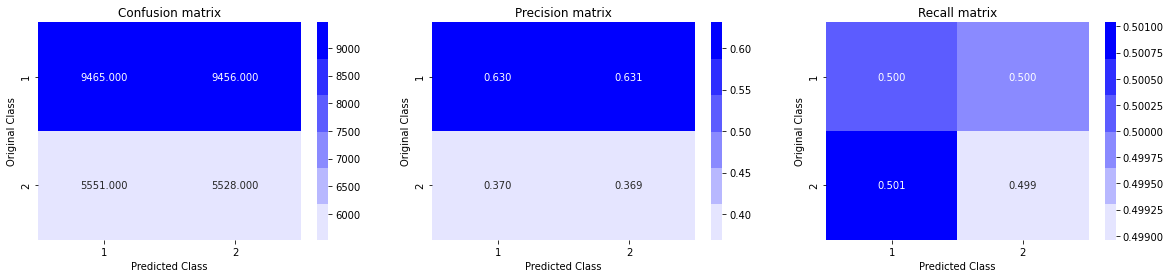

In [0]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 2. Logistic Regression with hyperparameter tuning 

For values of alpha =  1e-07 The log loss is: 0.4090589414979204
For values of alpha =  1e-06 The log loss is: 0.3988868712159295
For values of alpha =  1e-05 The log loss is: 0.3732089367531055
For values of alpha =  0.0001 The log loss is: 0.3966685627213073
For values of alpha =  0.001 The log loss is: 0.45614761824363353
For values of alpha =  0.01 The log loss is: 0.5144611465087484
For values of alpha =  0.1 The log loss is: 0.5468180090148933
For values of alpha =  1 The log loss is: 0.5576752494145414
For values of alpha =  10 The log loss is: 0.5648109551588324


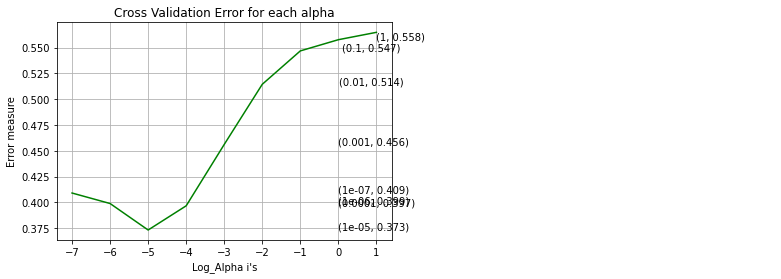

For values of best alpha =  1e-05 The train log loss is: 0.20766144260191635
For values of best alpha =  1e-05 The test log loss is: 0.37265288130795304
Total number of data points : 30000


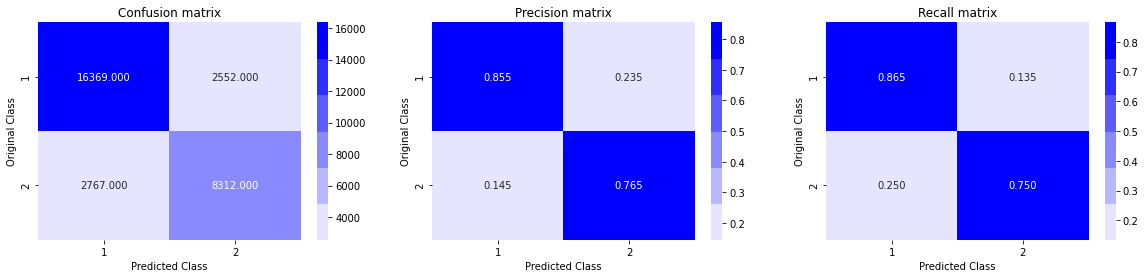

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import math

alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2',class_weight = "balanced", loss='log', random_state=21,n_jobs=6)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    
    
a = [math.log10(10 ** x) for x in range(-7, 2)]
fig, ax = plt.subplots()
ax.plot(a, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log_Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=21,n_jobs=6)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 3. Linear SVM with hyperparameter tuning

For values of alpha =  1e-08 The log loss is: 0.4009639274867782
For values of alpha =  1e-07 The log loss is: 0.40706390804075987
For values of alpha =  1e-06 The log loss is: 0.4090866426118164
For values of alpha =  1e-05 The log loss is: 0.40039631792530084
For values of alpha =  0.0001 The log loss is: 0.3966156632120013
For values of alpha =  0.001 The log loss is: 0.45747612197543475
For values of alpha =  0.01 The log loss is: 0.5229013836460963
For values of alpha =  0.1 The log loss is: 0.6058619839160266
For values of alpha =  1 The log loss is: 0.6585820784107572
For values of alpha =  10 The log loss is: 0.6585820784107572


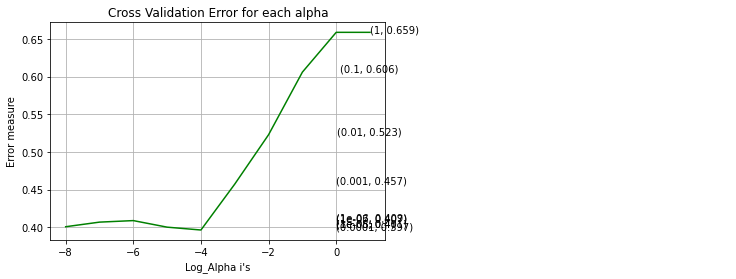

For values of best alpha =  0.0001 The train log loss is: 0.40335956197719486
For values of best alpha =  0.0001 The test log loss is: 0.39884298301400073
Total number of data points : 30000


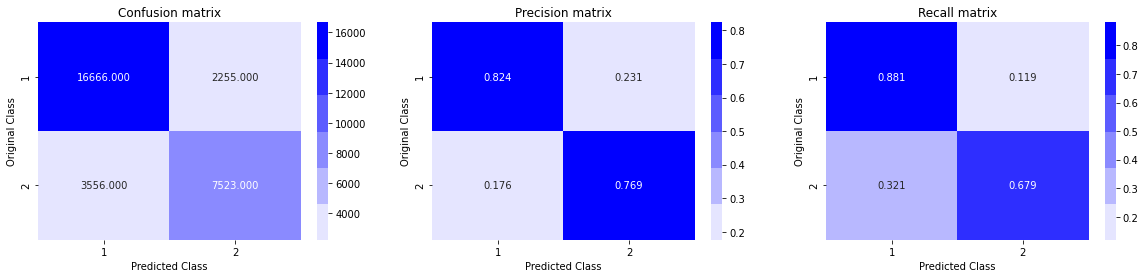

In [0]:
alpha = [10 ** x for x in range(-8, 2)]


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i,class_weight = "balanced", penalty='l1', loss='hinge', random_state=21,n_jobs=6)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

a = [math.log10(10 ** x) for x in range(-8, 2)]
fig, ax = plt.subplots()
ax.plot(a, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log_Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=21,n_jobs=6)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# TFIDF-W2V (make own WORD VEC)



In [0]:
!apt install rsync

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rsync is already the newest version (3.1.2-2.1ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
!unzip -q "/content/drive/My Drive/Copy of glove.42B.300d.zip"

downloading 'glove.6B.200d.txt' from kaggle due to 'glove.42B.300d.zip' is taking more time to compute.

In [0]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('/content/glove.42B.300d.txt')

864it [00:00, 8637.27it/s]

Loading Glove Model


1917495it [03:09, 10092.94it/s]

Done. 1917495  words loaded!


In [0]:
words = []
for i in X_train['preprocessed_q1'].values:
    words.extend(i.split(' '))

for i in X_train['preprocessed_q2']:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

all the words in the coupus 755815
the unique words in the coupus 36846
The number of words that are present in both glove vectors and our coupus 34665 ( 94.081 %)
word 2 vec length 34665


In [0]:
import pickle
with open('/content/glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(min_df = 5,ngram_range = (1,4),max_features=10000)
tfidf_model.fit(X_train['preprocessed_q1'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_train_tfidf_w2v_vectors_q1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_q1.append(vector)

print(len(X_train_tfidf_w2v_vectors_q1))
print(len(X_train_tfidf_w2v_vectors_q1[0]))

X_train_tfidf_w2v_vectors_q1 = normalize(X_train_tfidf_w2v_vectors_q1,axis=0)

100%|██████████| 69999/69999 [00:03<00:00, 18993.34it/s]


69999
300


In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_q1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_q1.append(vector)

print(len(X_test_tfidf_w2v_vectors_q1))
print(len(X_test_tfidf_w2v_vectors_q1[0]))

X_test_tfidf_w2v_vectors_q1 = normalize(X_test_tfidf_w2v_vectors_q1,axis=0)

100%|██████████| 30000/30000 [00:01<00:00, 19443.08it/s]


30000
300


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model2 = TfidfVectorizer(min_df = 5,ngram_range = (1,4),max_features=10000)
tfidf_model2.fit(X_train['preprocessed_q2'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model2.get_feature_names(), list(tfidf_model2.idf_)))
tfidf_words2 = set(tfidf_model2.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_train_tfidf_w2v_vectors_q2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words2):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_q2.append(vector)

print(len(X_train_tfidf_w2v_vectors_q2))
print(len(X_train_tfidf_w2v_vectors_q2[0]))

X_train_tfidf_w2v_vectors_q2 = normalize(X_train_tfidf_w2v_vectors_q2,axis=0)

100%|██████████| 69999/69999 [00:03<00:00, 18321.74it/s]


69999
300


In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_q2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words2):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_q2.append(vector)

print(len(X_test_tfidf_w2v_vectors_q2))
print(len(X_test_tfidf_w2v_vectors_q2[0]))

X_test_tfidf_w2v_vectors_q2 = normalize(X_test_tfidf_w2v_vectors_q2,axis=0)

100%|██████████| 30000/30000 [00:01<00:00, 17987.50it/s]


30000
300


In [0]:
# Merge TFIDF-W2v and all other tokenized features

X_train_tfidf_w2v = np.hstack((X_train_tfidf_w2v_vectors_q1,X_train_tfidf_w2v_vectors_q2,X_train_num_minmax))

X_test_tfidf_w2v = np.hstack((X_test_tfidf_w2v_vectors_q1,X_test_tfidf_w2v_vectors_q2,X_test_num_minmax))

print(X_train_tfidf_w2v.shape)
print(X_test_tfidf_w2v.shape)

(69999, 626)
(30000, 626)





# Train model using TFIDF - W2V

In [0]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params={
        "max_depth"               : [ 3, 4, 5, 6, 8, 10, 12, 15,20],
        "min_child_weight"        : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
       
  }
estimator1 = xgb.XGBClassifier(objective= 'binary:logistic',
eval_metric= 'logloss',scale_pos_weight = 1)
Rsearch1= RandomizedSearchCV(estimator1,param_distributions=params,scoring='neg_log_loss',n_jobs=-1,iid=False,  cv=5,verbose=21,random_state=21)
Rsearch1.fit(X_train_tfidf_w2v,y_train)
Rsearch1.best_params_, Rsearch1.best_score_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 77.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 86.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 116.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 137.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 147.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 168.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapse

({'max_depth': 8, 'min_child_weight': 1.0}, -0.33185418056896093)

In [0]:
w=Rsearch1.best_params_["min_child_weight"]
d=Rsearch1.best_params_['max_depth']
print(w)
print(d)

1.0
8


In [0]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params={

 "colsample_bytree"        : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'subsample'               :[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 
  }
estimator2 =xgb.XGBClassifier(objective= 'binary:logistic',
eval_metric= 'logloss',scale_pos_weight = 1,random_state=21,min_child_weight = w,max_depth = d)
Rsearch2= RandomizedSearchCV(estimator2,param_distributions=params,scoring='neg_log_loss',n_jobs=-1,iid=False, cv=5,verbose=21,random_state=21)
Rsearch2.fit(X_train_tfidf_w2v,y_train)
Rsearch2.best_params_, Rsearch2.best_score_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 78

({'colsample_bytree': 0.5, 'subsample': 1.0}, -0.33100446991814236)

In [0]:
c=Rsearch2.best_params_["colsample_bytree"]
s=Rsearch2.best_params_['subsample']

The train log loss is: 0.20681258070377484
The test log loss is: 0.348692281844108
Total number of data points : 30000


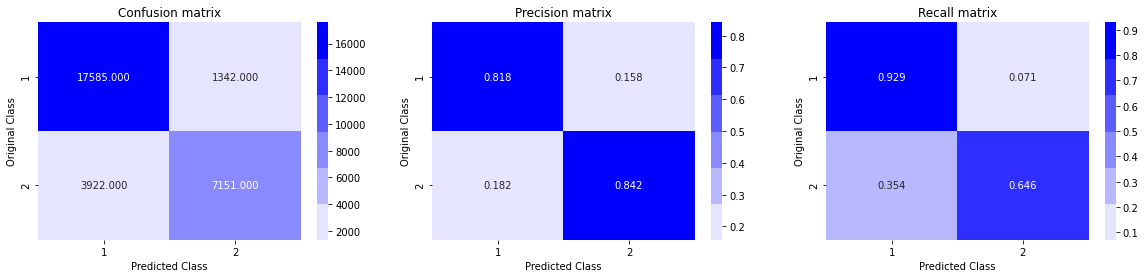

In [0]:
# train Final Xgboost model using all tunned hyperParameters

import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

estimator =xgb.XGBClassifier(objective= 'binary:logistic',
eval_metric= 'logloss',scale_pos_weight = 1,random_state=21,min_child_weight = w,max_depth = d,colsample_bytree = c, subsample = s)
estimator.fit(X_train_tfidf_w2v,y_train)

predict_y = estimator.predict_proba(X_train_tfidf_w2v)
print("The train log loss is:",log_loss(y_train, predict_y, labels=estimator.classes_, eps=1e-15))

predict_y = estimator.predict_proba(X_test_tfidf_w2v)
print("The test log loss is:", log_loss(y_test, predict_y, labels=estimator.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [1]:
from prettytable import PrettyTable

ptable = PrettyTable()

ptable.title = " Model Comparision "
ptable.field_names = ['Serial No.', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["1","Random","TFIDF","-","0.88"])
ptable.add_row(["2","Logistic Regression","TFIDF Weighted W2V","Done","0.37"])
ptable.add_row(["3","Linear SVM","TFIDF Weighted W2V","Done","0.39"])

ptable.add_row(["\n","\n","\n","\n","\n"])


ptable.add_row(["1","XGBoost","TFIDF Weighted W2V","Done","0.35"])
print(ptable)

+------------+---------------------+--------------------+------------------------+---------------+
| Serial No. |      Model Name     |     Tokenizer      | Hyperparameter Tunning | Test Log Loss |
+------------+---------------------+--------------------+------------------------+---------------+
|     1      |        Random       |       TFIDF        |           -            |      0.88     |
|     2      | Logistic Regression | TFIDF Weighted W2V |          Done          |      0.37     |
|     3      |      Linear SVM     | TFIDF Weighted W2V |          Done          |      0.39     |
|            |                     |                    |                        |               |
|            |                     |                    |                        |               |
|     1      |       XGBoost       | TFIDF Weighted W2V |          Done          |      0.35     |
+------------+---------------------+--------------------+------------------------+---------------+
